In [31]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.base import clone, BaseEstimator
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
mnist.DESCR

"**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  \n**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  \n**Please cite**:  \n\nThe MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  \n\nIt is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 

In [5]:
mnist.details

{'id': '554',
 'name': 'mnist_784',
 'version': '1',
 'description_version': '2',
 'format': 'ARFF',
 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'],
 'upload_date': '2014-09-29T03:28:38',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://api.openml.org/data/v1/download/52667/mnist_784.arff',
 'parquet_url': 'https://data.openml.org/datasets/0000/0554/dataset_554.pq',
 'file_id': '52667',
 'default_target_attribute': 'class',
 'tag': ['Artificial Intelligence',
  'AzurePilot',
  'Computer Vision',
  'Data Sets',
  'Kaggle',
  'Machine Learning',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_41',
  'study_99',
  'vision'],
 'visibility': 'public',
 'minio_url': 'https://data.openml.org/datasets/0000/0554/dataset_554.pq',
 'status': 'active',
 'processing_date': '2020-11-20 20:12:09',
 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}

In [6]:
X = mnist.data
y = mnist.target.astype(int)

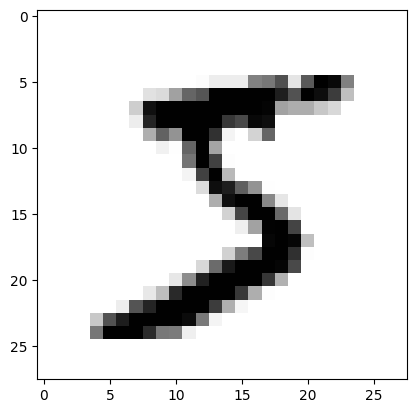

In [7]:
first_digit = X.loc[0]
first_digit_image = first_digit.values.reshape(28, 28)
plt.imshow(first_digit_image, cmap='binary')
plt.show()

In [8]:
y[0]

5

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [10]:
# Create a Binary Classifier (can only recognize one digit)

# let's prepare data for train
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# create a SDGClassifier
sdg_clf = SGDClassifier(random_state=42)
# train the classifier
sdg_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sdg_clf.predict([first_digit]) # True means it is a 5

C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [12]:
skfolds = StratifiedKFold(n_splits=3) # like cross-validation but preserves the percentage of samples for each class
for train_index, test_index in skfolds.split(X_train, y_train_5):
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf = clone(sdg_clf)
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # accuracy 0.9676, 0.9599, 0.96601

0.9676313401230211
0.9599657137094741
0.9660162355669843


In [13]:
# let's use cross_val_score to do the same thing
cross_val_score(
    sdg_clf,
    X_train,
    y_train_5,
    cv=3,
    scoring='accuracy'
) # array([0.96763134, 0.95996571, 0.96601624])

array([0.96763134, 0.95996571, 0.96601624])

In [14]:
# Let's create a DummyClassifier that return always True
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)  # always return False

In [15]:
# Let's test accuracy of our DummyClassifier
never_5_clf = Never5Classifier()

cross_val_score(
    never_5_clf,
    X_train,
    y_train_5,
    cv=3,
    scoring='accuracy'
)

array([0.91146516, 0.90893965, 0.91020017])

In [16]:
y_train_predict = cross_val_predict(sdg_clf, X_train, y_train_5, cv=3)

In [17]:
confusion_matrix(
    y_train_5,
    y_train_predict
)

array([[53310,   847],
       [ 1263,  4080]], dtype=int64)

In [18]:
report = classification_report(y_train_5, y_train_predict)

In [19]:
# let's calculate recall, precision and f1 score
precision = precision_score(y_train_5, y_train_predict) # or TP/(TP + FP)
recall = recall_score(y_train_5, y_train_predict) # or TP/(TP + FN)
f1 = f1_score(y_train_5, y_train_predict) # or 2 * (precision * recall) / (precision + recall)

In [20]:
# let's setup decision threshold

y_scores = sdg_clf.decision_function([first_digit]) # 3156.0
threshold = 0
y_some_digit_pred = (y_scores > threshold) # 3156 > 0 -> that's mean True

C:\Users\Tymur_Hilfatullin\Projects\ML\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [21]:
# let's use cross_val_predict to get decision scores for each instance
y_scores = cross_val_predict(
    sdg_clf,
    X_train,
    y_train_5,
    cv=3,
    method='decision_function'
)

In [22]:
y_scores.mean(), y_scores.std(), y_scores.min(), y_scores.max()

(-16494.38624407057, 13583.347327506093, -140986.7948495201, 53614.57352982995)

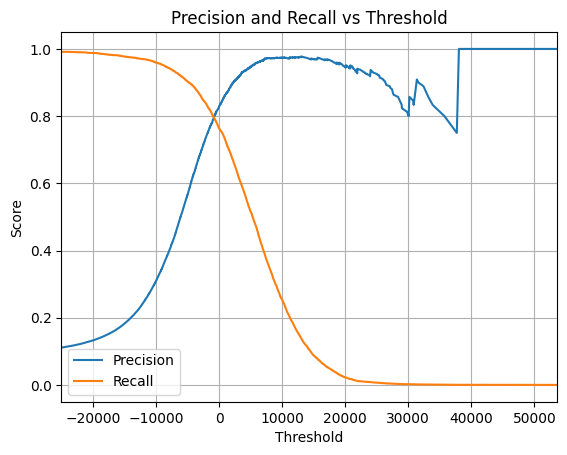

In [23]:
# let's use precision_recall_curve to get precision and recall for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# let's plot precision and recall

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, limit=-25000):
    plt.plot(thresholds, precisions[:-1], label='Precision')
    plt.plot(thresholds, recalls[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.title('Precision and Recall vs Threshold')
    plt.xlim([limit, thresholds.max()])
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [24]:
# let's assume we want a precision of 90% (what threshold we need?)
desired_precision = 0.9
threshold_90_precision = thresholds[np.argmax(precisions >= desired_precision)] # 2242.2

In [25]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90) # accuracy vs recall

(0.9001261034047919, 0.6679767920643833)

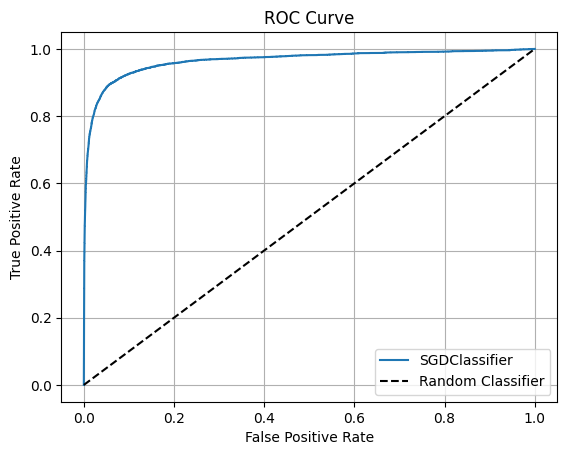

In [33]:
# ROC Curve (receiver operating characteristic curve)
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

plot_roc_curve(fpr, tpr, 'SGDClassifier')

In [28]:
# let's calculate AUC (Area Under the Curve)
# For Best Classifier, AUC should be close to 1
roc_auc_score(
    y_train_5,
    y_scores
)

0.9655057380239735

In [32]:
# Let's learn how to use RandomForestClassifier and compare it with SGDClassifier by ROC AUC

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv=3,
    method='predict_proba' # RandomForestClassifier has predict_proba method, so we can use it to get probabilities
)

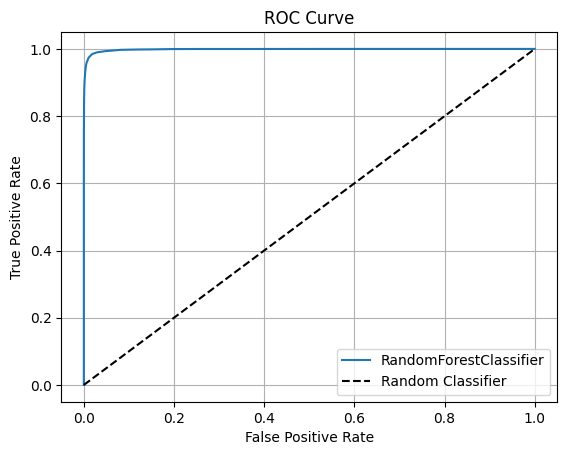

In [34]:
y_scores_forest = y_probas_forest[:, 1]  # get the probability of the positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest) # get fpr and tpr for RandomForestClassifier
plot_roc_curve(fpr_forest, tpr_forest, 'RandomForestClassifier') # plot ROC Curve for RandomForestClassifier

In [35]:
# calculate AUC for RandomForestClassifier 0.9985
roc_auc_score(
    y_train_5,
    y_scores_forest
)

0.9984737275326855